In [1]:
import sys
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path

In [2]:
from src.main import *
from matplotlib import rc

%matplotlib widget
rc("text", usetex=True)
rc("font", family="serif")
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)
rc("font", size=18)
rc("legend", fontsize=16)
rc("text.latex", preamble=r"\usepackage{siunitx}")

In [3]:
Delta = 1.0

In [4]:
list_n = [10, 100, 500, 1000, 5000]  # , 10000, 100000, 500000]
list_x = [
    np.linspace(
        0.5 * Delta / (k * int(Delta)),
        Delta - 0.5 * Delta / (k * int(Delta)),
        k * int(Delta),
    )
    for k in list_n
]
list_xf = [np.linspace(0.0, Delta, k * int(Delta) + 1) for k in list_n]

x = list_x[0]
xf = list_xf[0]
# print('I : ', bulle.indicatrice_liquide(x))
# print('If : ', bulle.indicatrice_liquide(xf))

In [5]:
def test_cvgce_order(function):
    np.seterr(all="ignore")
    list_scheme = ["upwind", "center", "center_h", "quick", "weno"]
    list_labels = ["Upwind", "Center", "Center\_h", "QUICK", "WENO"]
    fig, ax = plt.subplots(1)
    for i_scheme, scheme in enumerate(list_scheme):
        print("=================")
        print("| Interpolation |")
        print("=================")
        print(scheme)
        err_schema = []
        dx_list = []
        # figT, axT = plt.subplots(1)
        for i in range(len(list_x)):
            x = list_x[i]
            xf = list_xf[i]
            dx = x[1] - x[0]
            dx_list.append(dx)
            T = function(x)
            T_f = function(xf)
            T_int = interpolate(T, schema=scheme)
            err_schema.append(np.sum(np.abs(T_f - T_int) * dx))
            # axT.plot(xf, T_int, label=i)
        # axT.plot(xf, T_f, '+', label='Ref')
        # axT.legend()
        # axT.set_title(scheme)
        slope, intercept, r_value, p_value, std_err = linregress(
            np.log(dx_list), np.log(err_schema)
        )
        print("Ordre : ", slope)
        print(r"$R^2$ : ", r_value**2)
        ax.loglog(
            dx_list,
            err_schema,
            label=list_labels[i_scheme]
            + r", $\mathcal{O}(\Delta x^{%.3g})$" % (slope,)
            + r", $R^2 = %g$" % (r_value**2,),
        )
        ax.set_xlabel(r"$\Delta x$")
        ax.set_ylabel(r"$\int_{L}{\left| T_{interp} - T_f \right| dx}$")
        ax.legend()
        ax.minorticks_on()
        ax.grid(visible=True, which="major")
        ax.grid(visible=True, which="minor", alpha=0.2)
    return fig, ax

# Ordre de convergence de l'interpolation

## Avec un sinus

In [6]:
def sinus(x):
    return np.sin(x * 2 * np.pi / Delta)


# returns the sine integral between x-dx/2. and x+dx/2.
def int_sinus(x):
    dx = x[1] - x[0]
    res = (
        -Delta
        / (2 * np.pi)
        * (
            np.cos((x + dx / 2.0) * 2 * np.pi / Delta)
            - np.cos((x - dx / 2.0) * 2.0 * np.pi / Delta)
        )
        / dx
    )
    return res
    # return get_T_creneau(x, phy_prop=phy_prop, markers=bulle)

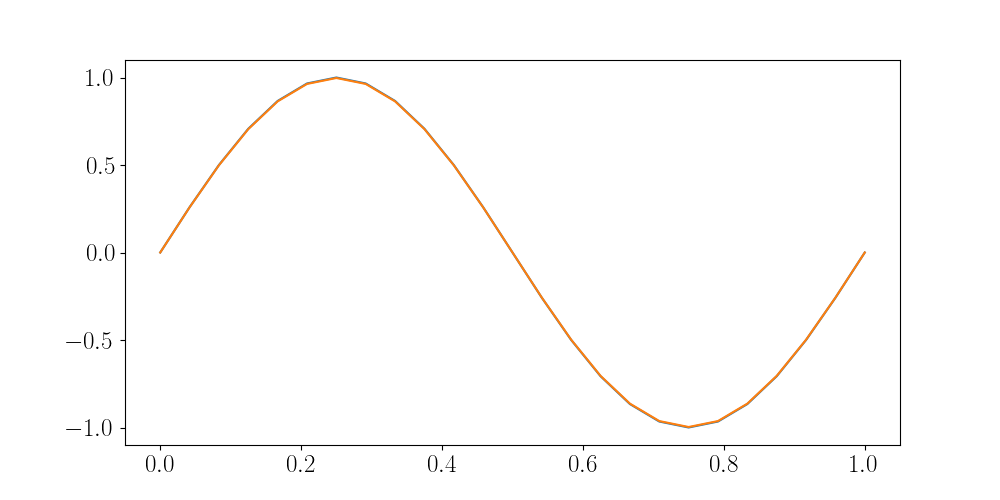

In [7]:
x = np.linspace(0.0, 1.0, 25)
y = sinus(x)
y1 = int_sinus(x)
plt.figure()
plt.plot(x, y)
plt.plot(x, y1)

| Interpolation |
upwind
Ordre :  1.0224253418357305
$R^2$ :  0.9998191800788256
| Interpolation |
center
Ordre :  1.9936064146722758
$R^2$ :  0.999994582628658
| Interpolation |
center_h
Ordre :  1.7138306824963354
$R^2$ :  0.9982272252574688
| Interpolation |
quick
Ordre :  2.7870505032370794
$R^2$ :  0.997069987289377
| Interpolation |
weno
Ordre :  2.0099139511946933
$R^2$ :  0.9999866323120541


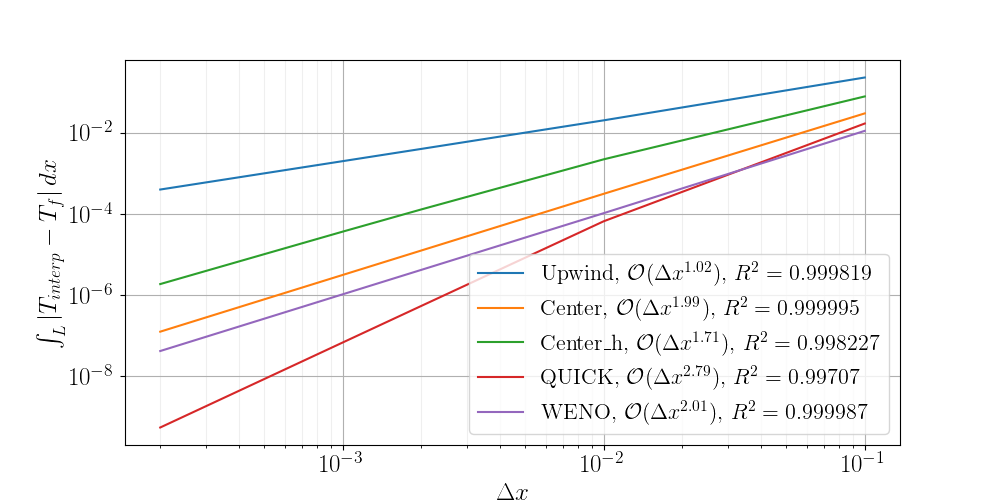

In [8]:
fig, _ = test_cvgce_order(sinus)
# fig.savefig(os.path.join(lib_path, 'figures', 'convergence_operateurs_base', 'sin.pdf'))

On constate de manière attendue que le schéma upwind est d'ordre 1, le schéma centré d'ordre 2, le schéma centré harmonique est d'ordre un peu inférieur (1.86).

Comme prévu le schéma QUICK est d'ordre 3, en revanche de manière surprenante le WENO est d'ordre 2.

## Avec un creneau

In [9]:
x0 = 3.75 / 12.0
x1 = 7.25 / 12.0


def creneau(x):
    res = np.where(np.bitwise_and(x0 < x, x < x1), 1.0, 0.0)
    return res


def int_creneau(x):
    dx = x[1] - x[0]
    res = np.where(np.bitwise_and(x0 < x, x < x1), 1.0, 0.0)
    ind_0 = np.abs(x - x0) < dx / 2.0
    res[ind_0] = (x[ind_0] + dx / 2.0 - x0) / dx
    ind_1 = np.abs(x - x1) < dx / 2.0
    res[ind_1] = 1.0 - (x[ind_1] + dx / 2.0 - x1) / dx
    return res

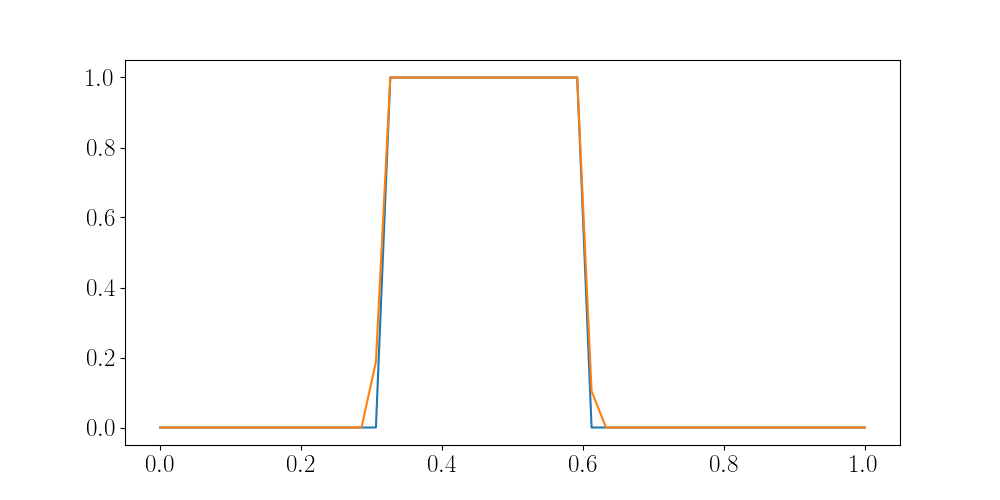

In [10]:
x = np.linspace(0.0, 1, 50)
y = creneau(x)
y1 = int_creneau(x)
plt.figure()
plt.plot(x, y)
plt.plot(x, y1)

| Interpolation |
upwind
Ordre :  0.9999999999999415
$R^2$ :  0.9999999999999996
| Interpolation |
center
Ordre :  0.8047921026590918
$R^2$ :  0.9549881387586561
| Interpolation |
center_h
Ordre :  1.025640551765483
$R^2$ :  0.9989683836203196
| Interpolation |
quick
Ordre :  0.9610880181109256
$R^2$ :  0.9885599443470903
| Interpolation |
weno
Ordre :  1.048394887219534
$R^2$ :  0.9970522528290264


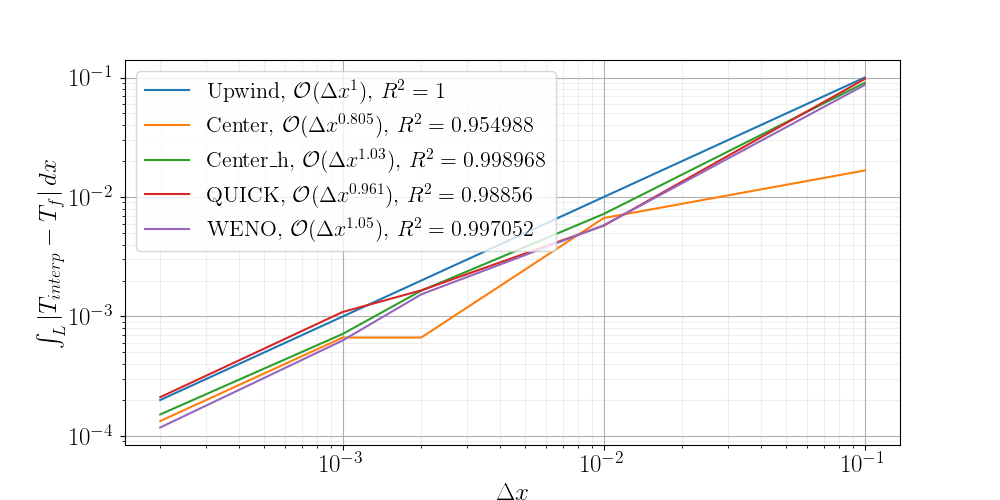

In [11]:
fig, _ = test_cvgce_order(int_creneau)
# fig.savefig(os.path.join(lib_path, 'figures', 'convergence_operateurs_base', 'creneau.pdf'))

On en conclut que tous les schémas d'interpolation de créneaux étudiés ici sont d'ordre 1.
En effet, la seule erreur d'interpolation est faite ici à proximité des interfaces et l'intégrale de l'erreur donne une convergence à l'ordre 1.

# Ordre de convergence en volume fini sur un pas

In [12]:
def test_cvgce_vdf_order(function, int_function):
    np.seterr(all="ignore")
    list_scheme = ["upwind", "center", "center_h", "quick", "weno"]
    list_labels = ["Upwind", "Center", "Center\_h", "QUICK", "WENO"]
    fig, ax = plt.subplots(1)
    for i_scheme, scheme in enumerate(list_scheme):
        print("=================")
        print("| Interpolation |")
        print("=================")
        print(scheme)
        err_schema = []
        dx_list = []
        # figT, axT = plt.subplots(1)
        for i in range(len(list_x)):
            x = list_x[i]
            xf = list_xf[i]
            dx = x[1] - x[0]
            dx_list.append(dx)
            T = int_function(x)
            T_int = interpolate(T, schema=scheme)
            divT_int = (T_int[1:] - T_int[:-1]) / dx
            T_f = function(xf)
            divT_f = (T_f[1:] - T_f[:-1]) / dx
            err_schema.append(np.sum(np.abs(divT_f - divT_int) * dx))
            # axT.plot(xf, T_int, label=i)
        # axT.plot(xf, T_f, '+', label='Ref')
        # axT.legend()
        # axT.set_title(scheme)
        slope, intercept, r_value, p_value, std_err = linregress(
            np.log(dx_list), np.log(err_schema)
        )
        print("Ordre : ", slope)
        print(r"$R^2$ : ", r_value**2)
        ax.loglog(
            dx_list,
            err_schema,
            label=list_labels[i_scheme]
            + r", $\mathcal{O}(\Delta x^{%.3g})$" % (slope,)
            + r", $R^2 = %g$" % (r_value**2,),
        )
        ax.set_xlabel(r"$\Delta x$")
        ax.set_ylabel(r"$\int_{L}{\left| \nabla T_{interp} - \nabla T_f \right| dx}$")
        ax.legend()
        ax.minorticks_on()
        ax.grid(visible=True, which="major")
        ax.grid(visible=True, which="minor", alpha=0.2)
    return fig, ax

# Pour un sinus

| Interpolation |
upwind
Ordre :  0.9949642127271279
$R^2$ :  0.9999865142209025
| Interpolation |
center
Ordre :  1.9893550082978768
$R^2$ :  0.999984568302601
| Interpolation |
center_h
Ordre :  0.9480881838065734
$R^2$ :  0.998689340516599
| Interpolation |
quick
Ordre :  1.7142712769421578
$R^2$ :  0.9853237238338742
| Interpolation |
weno
Ordre :  3.2453030901825763
$R^2$ :  0.793406330371031


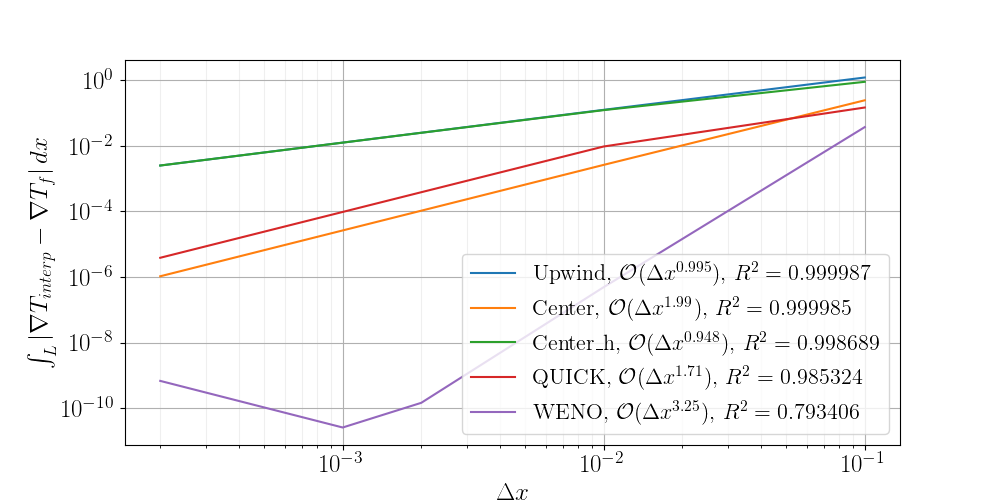

In [13]:
fig, _ = test_cvgce_vdf_order(sinus, int_sinus)
# fig.savefig(os.path.join(lib_path, 'figures', 'convergence_operateurs_base', 'sin.pdf'))

On constate de manière attendue que le schéma upwind est d'ordre 1, le schéma centré d'ordre 2, le schéma centré harmonique est d'ordre 1.

De manière surprenante, les schémas QUICK et WENO sont d'ordre 2.

## Pour un creneau

| Interpolation |
upwind
Ordre :  -0.28208778564915704
$R^2$ :  0.7134704232778915
| Interpolation |
center
Ordre :  -1.6885154654374842e-17
$R^2$ :  0.5181449891360609
| Interpolation |
center_h
Ordre :  0.07413384259228673
$R^2$ :  0.18128228681438743
| Interpolation |
quick
Ordre :  -0.13181491514352642
$R^2$ :  0.7080405139587607
| Interpolation |
weno
Ordre :  -0.26732619372971306
$R^2$ :  0.5097534739469196


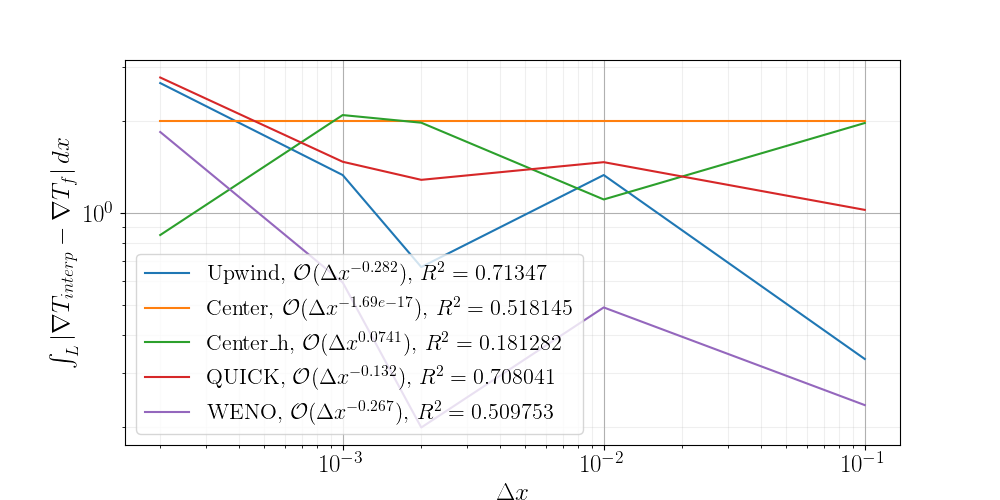

In [14]:
fig, _ = test_cvgce_vdf_order(creneau, int_creneau)
# fig.savefig(os.path.join(lib_path, 'figures', 'convergence_operateurs_base', 'creneau.pdf'))

On en conclut que tous les schémas d'interpolation de créneaux étudiés ici sont d'ordre 1.
En effet, la seule erreur d'interpolation est faite ici à proximité des interfaces et l'intégrale de l'erreur donne une convergence à l'ordre 1.

# Test avec plusieurs itérations en interpolation et réinterpolation successives

In [15]:
def eval_interp_iterative(function, n=100, step=10):
    dx = 1.0 / n
    x = np.linspace(dx / 2.0, 1.0 - dx / 2, n)
    y = function(x)
    plt.figure()
    plt.plot(x, y, label="Ref")
    list_scheme = ["upwind", "center", "quick", "weno"]
    for schema in list_scheme:
        y_int = y[:]
        for i in range(step):
            if i % 2 == 0:
                y_int = interpolate(y_int, schema=schema, cl=1)
            else:
                y_int = interpolate(y_int, schema=schema, cl=1)
                y_int = y_int[1:-1]

        plt.plot(x, y_int, label=schema)
    xf = np.empty(x.size + 1)
    xf[:-1] = x - dx / 2.0
    xf[-1] = x[-1] + dx / 2
    plt.legend()
    plt.grid()
    ti = plt.gca().set_xticks(xf)
    la = plt.gca().set_xticklabels([])

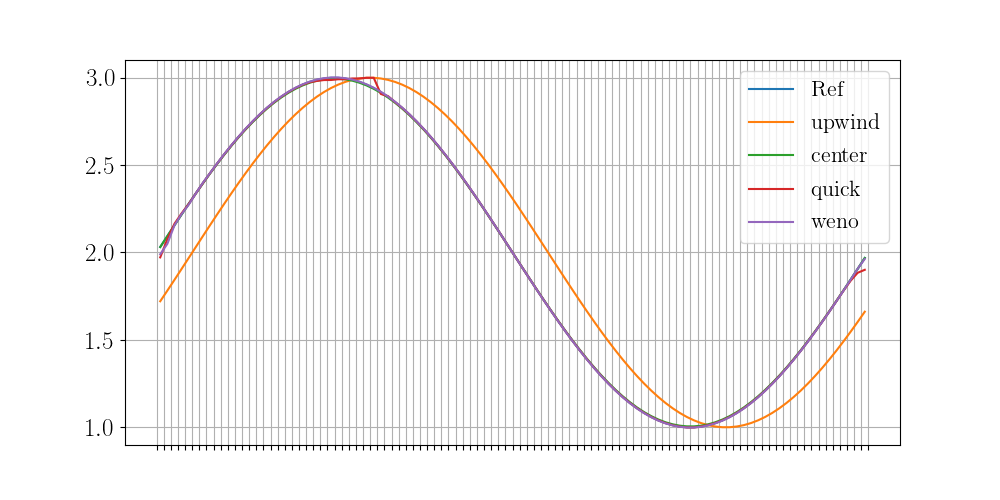

In [16]:
eval_interp_iterative(lambda x: sinus(x) + 2.0)

# Test avec plusieurs itérations en Euler explicit

## Profil

In [17]:
def plot_profil(ax, x, y, lab=None):
    ax.plot(x, y, label=lab)
    ax.legend()
    ax.grid(visible=True)
    ax.set_xticks(xf)
    ax.set_xticklabels([])

In [18]:
def eval_interp_euler_conv(function, n=200, step=10, cfl=0.5):
    dx = 1.0 / n
    dt = dx * cfl
    x = np.linspace(dx / 2.0, 1.0 - dx / 2, n)
    y = function(x)
    plt.figure()
    plt.plot(x, y, label="Ref")
    list_scheme = ["upwind", "quick", "weno"]
    for schema in list_scheme:
        y_int = y.copy()
        for i in range(step):
            flux = interpolate(y_int, schema=schema, cl=1)
            y_int += dt * (flux[:-1] - flux[1:]) / dx
        plt.plot(x, y_int, label=schema)
    xf = np.empty(x.size + 1)
    xf[:-1] = x - dx / 2.0
    xf[-1] = x[-1] + dx / 2
    plt.legend()
    plt.grid()
    ti = plt.gca().set_xticks(xf)
    la = plt.gca().set_xticklabels([])

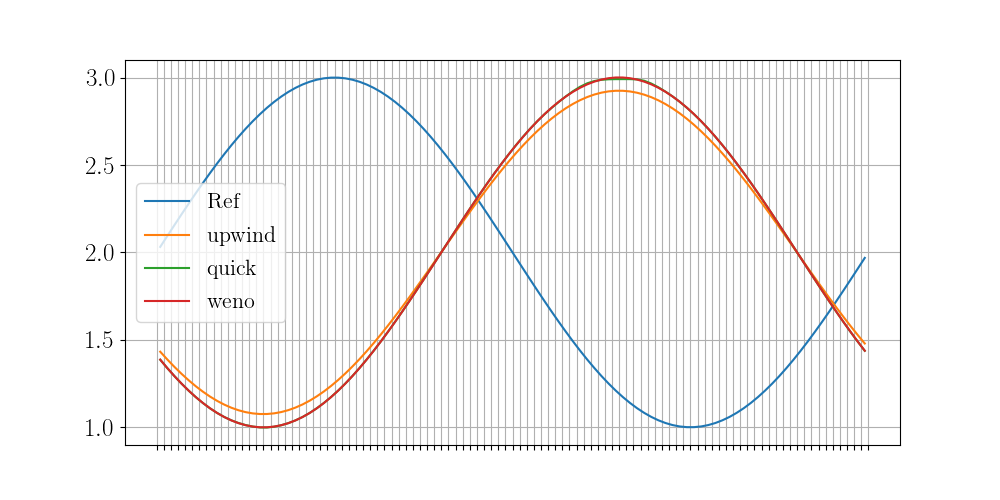

In [19]:
eval_interp_euler_conv(lambda x: sinus(x) + 2.0, n=100, step=4000, cfl=0.01)

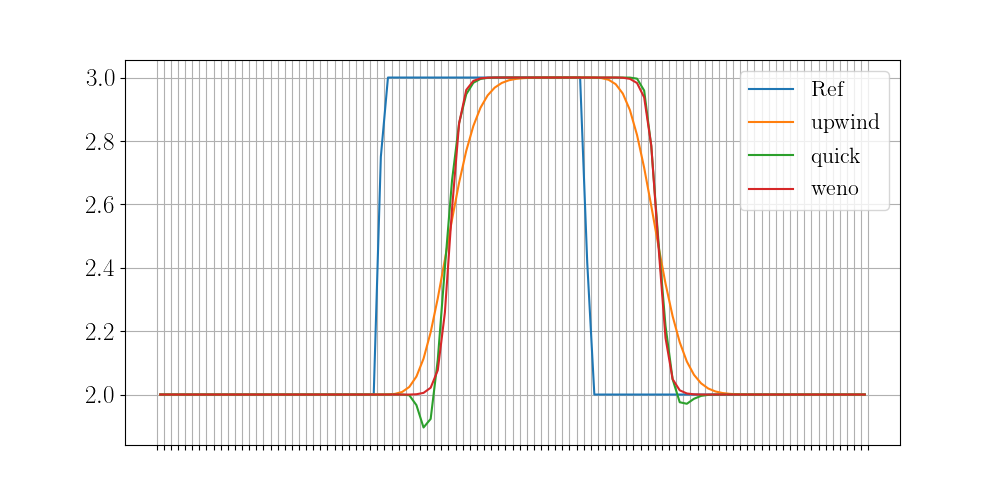

In [20]:
eval_interp_euler_conv(lambda x: int_creneau(x) + 2.0, n=100, step=1000, cfl=0.01)

## Ordre de convergence

In [32]:
def eval_convergence_euler_conv(
    function, n_list=[50, 100], n_tour_domaine=0.03, cfl=0.0001
):
    already_plotted_ref = False
    v = 1.0
    D = 1.0
    n_array = np.array(n_list)
    dx_array = D / n_array
    dt = np.min(dx_array / v * cfl)
    print("dt : ", dt)
    step = int(n_tour_domaine * D / (v * dt))
    fig, ax = plt.subplots(1)
    fig_prof, (ax_prof, ax_err) = plt.subplots(nrows=2, sharex=True)
    list_scheme = ["upwind", "quick", "weno"]
    for schema in list_scheme:
        err_pour_schema = []
        for k, n in enumerate(n_array):
            dx = dx_array[k]
            x = np.linspace(dx / 2.0, D - dx / 2, n)
            y = function(x)
            y_int = y.copy()
            for _ in range(step):
                flux = interpolate(y_int * v, schema=schema, cl=1)
                y_int += dt * (flux[:-1] - flux[1:]) / dx
            y_ref = function(x - step * v * dt)
            err_pour_schema.append(np.sqrt(np.sum((y_ref - y_int) ** 2.0)) / n)
            if k == len(n_array) - 1:
                if not already_plotted_ref:
                    plot_profil(ax_prof, x, y_ref, "Ref")
                    plot_profil(ax_err, [], [], "Ref")
                    already_plotted_ref = True
                plot_profil(ax_prof, x, y_int, schema)
                ax_err.semilogy(x, np.abs(y_ref - y_int), label=schema)
                ax_err.legend()
        err_pour_schema_arr = np.array(err_pour_schema)
        slope, intercept, r_value, p_value, std_err = linregress(
            np.log(dx_array), np.log(err_pour_schema_arr)
        )
        ax.loglog(
            dx_array,
            err_pour_schema_arr,
            "-+",
            label=schema
            + r", $\mathcal{O}(\Delta x^{%.3g})$" % (slope,)
            + r", $R^2 = %g$" % (r_value**2,),
        )
        print()
        print(schema, slope)
        print(r"R^2", r_value**2.0)
    ax_err.set_ylabel("Erreur")
    ax_prof.set_ylabel("Solution")
    ax_err.set_xlabel(r"$x$")
    fig_prof.tight_layout()
    fig_prof.savefig(
        os.path.join(
            lib_path,
            "figures",
            "convergence_operateurs_base",
            "euler_creneau_profil.pdf",
        )
    )
    ax.grid(visible=True, which="major")
    ax.grid(visible=True, which="minor", alpha=0.2)
    ax.set_xlabel(r"$\Delta x$")
    ax.set_ylabel(r"$\epsilon$")
    ax.legend()
    fig.tight_layout()
    fig.savefig(
        os.path.join(
            lib_path,
            "figures",
            "convergence_operateurs_base",
            "euler_creneau_erreur.pdf",
        )
    )

dt :  2.0000000000000003e-06

upwind 1.460035174009346
R^2 0.9999307735967031


/home/as259691/PycharmProjects/FluidDyn1D/venv-flu1d/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()



quick 2.2550350972647655
R^2 0.9998760324477028

weno 5.660296635157494
R^2 0.99973191365036


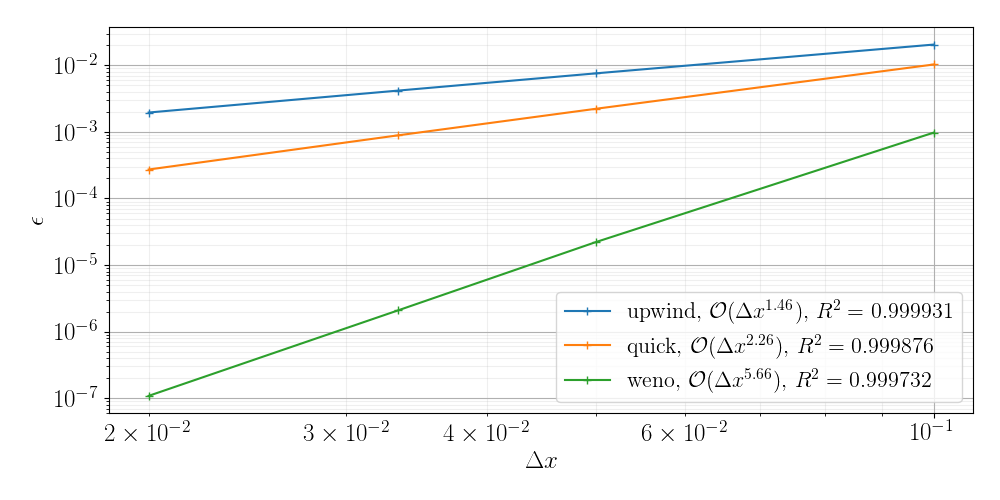

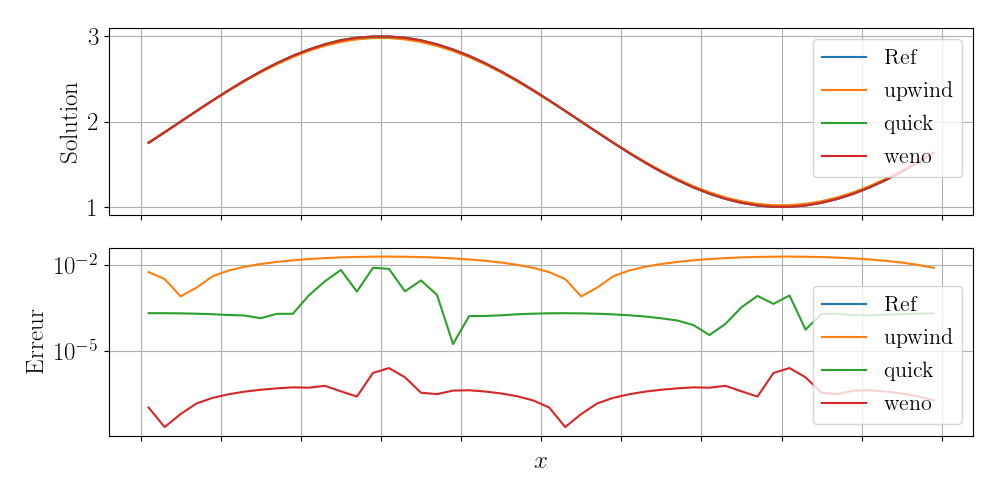

In [31]:
eval_convergence_euler_conv(
    lambda x: int_sinus(x) + 2.0,
    n_list=[10, 20, 30, 50],
    cfl=0.0001,
    n_tour_domaine=0.05,
)

dt :  2e-05

upwind 0.6755619842014863
R^2 0.9991955124110475

quick 0.7907206797437892
R^2 0.9956403976864822

weno 0.7711732487463624
R^2 0.9935023829325312


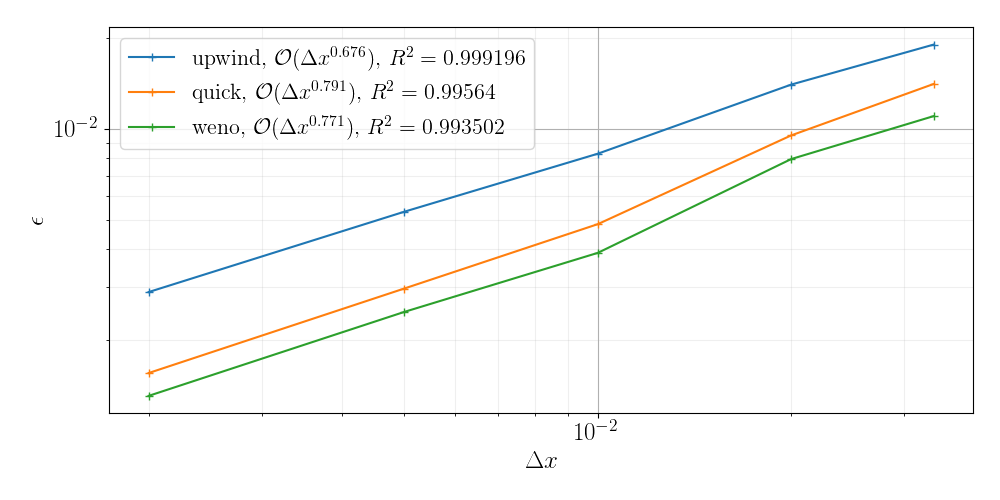

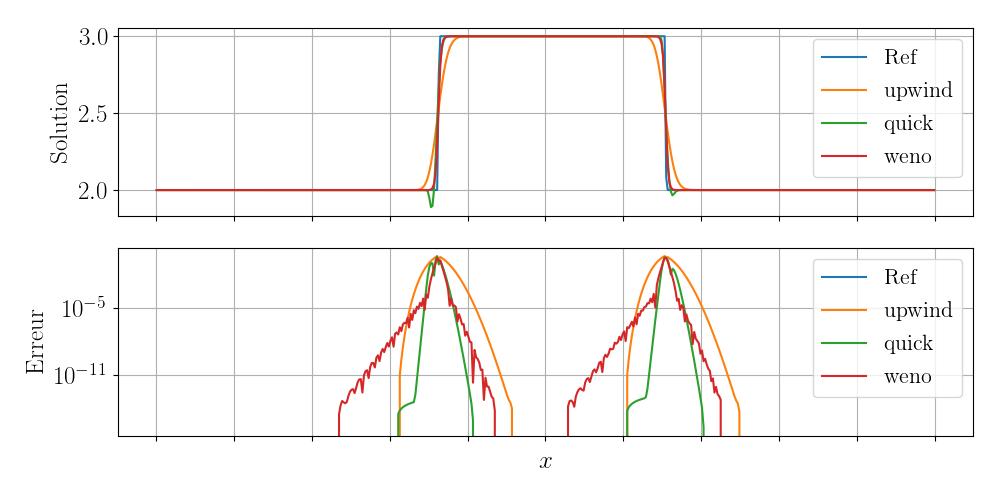

In [33]:
eval_convergence_euler_conv(
    lambda x: int_creneau(x) + 2.0,
    n_list=[30, 50, 100, 200, 500],
    cfl=0.01,
    n_tour_domaine=0.05,
)